In [10]:
%pip install -U langgraph langchain_community langchain_anthropic langchain_experimental

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
%pip install python-dotenv langchain_groq


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:

import getpass
import os
from dotenv import find_dotenv, load_dotenv
from langchain_groq import ChatGroq

dotenv_path = find_dotenv()
load_dotenv(dotenv_path)
groq_api_key = os.getenv("groq_api_key")
os.environ["groq_api_key"] = groq_api_key 

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("groq_api_key")

dotenv_path = find_dotenv()
load_dotenv(dotenv_path)
tavily_api_key = os.getenv("tavily_api_key")
os.environ["tavily_api_key"] = tavily_api_key

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("tavily_api_key")

In [3]:
from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL

tavily_tool = TavilySearchResults(max_results=5)

# This executes code locally, which can be unsafe
repl = PythonREPL()


@tool
def python_repl_tool(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code and do math. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    result_str = f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"
    return result_str

<>:23: SyntaxWarning: invalid escape sequence '\`'
<>:23: SyntaxWarning: invalid escape sequence '\`'
<>:23: SyntaxWarning: invalid escape sequence '\`'
<>:23: SyntaxWarning: invalid escape sequence '\`'
C:\Users\paulo\AppData\Local\Temp\ipykernel_17120\2391770398.py:23: SyntaxWarning: invalid escape sequence '\`'
  result_str = f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"
C:\Users\paulo\AppData\Local\Temp\ipykernel_17120\2391770398.py:23: SyntaxWarning: invalid escape sequence '\`'
  result_str = f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"


In [ ]:
from typing import Literal
from typing_extensions import TypedDict

from langchain_anthropic import ChatAnthropic
from langgraph.graph import MessagesState, END
from langgraph.types import Command


members = ["researcher", "coder","expenses_manager"]
# Our team supervisor is an LLM node. It just picks the next agent to process
# and decides when the work is completed
options = members + ["FINISH"]

system_prompt = (
    "You are a supervisor tasked with managing a conversation between the"
    f" following workers: {members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When you done what the user ask or got an answer,"
    " respond with FINISH."
)


class Router(TypedDict):
    """Worker to route to next. If no workers needed, route to FINISH."""

    next: Literal[*options]


#llm = ChatAnthropic(model="claude-3-5-sonnet-latest")

llm=ChatGroq(groq_api_key=groq_api_key,model_name="Llama-3.3-70b-Versatile")
class State(MessagesState):
    next: str


def supervisor_node(state: State) -> Command[Literal[*members, "__end__"]]:
    messages = [
        {"role": "system", "content": system_prompt},
    ] + state["messages"]
    response = llm.with_structured_output(Router).invoke(messages)
    goto = response["next"]
    if goto == "FINISH":
        goto = END

    

    return Command(goto=goto, update={"next": goto})

In [ ]:
from langchain_core.messages import HumanMessage
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import create_react_agent


research_agent = create_react_agent(
    llm, tools=[tavily_tool], prompt="You are a researcher.DO not perform any math operations but you can output numbers"
)


def research_node(state: State) -> Command[Literal["supervisor"]]:
 
    result = research_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="researcher")
            ]
        },
        goto="supervisor",
    )


# NOTE: THIS PERFORMS ARBITRARY CODE EXECUTION, WHICH CAN BE UNSAFE WHEN NOT SANDBOXED
code_agent = create_react_agent(llm, tools=[python_repl_tool])


def code_node(state: State) -> Command[Literal["supervisor"]]:

    result = code_agent.invoke(state)

    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="coder")
            ]
        },
        goto="supervisor",
    )


import json
# Load the JSON file
file_path = "monthly_expenses.json"  # Replace with the correct path to your file
with open(file_path, "r") as file:
    data = json.load(file)

# Convert the JSON data to a string
monthly_expenses_json_string = json.dumps(data, indent=4)  # Pretty-printed string

expenses_manager_agent = create_react_agent(llm, tools=[],prompt=f"You are a expenses manager. you data is solely based here{monthly_expenses_json_string}")

def expenses_manager_node(state: State) -> Command[Literal["supervisor"]]:

    result = expenses_manager_agent.invoke(state)

    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="expenses_manager")
            ]
        },
        goto="supervisor",
    )


builder = StateGraph(State)
builder.add_edge(START, "supervisor")
builder.add_node("supervisor", supervisor_node)
builder.add_node("researcher", research_node)
builder.add_node("coder", code_node)
builder.add_node("expenses_manager", expenses_manager_node)
graph = builder.compile()

TypeError: create_react_agent() got an unexpected keyword argument 'max_iterations'

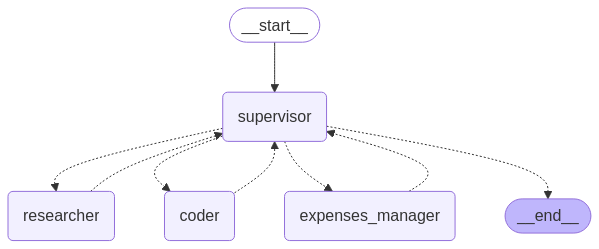

In [17]:
from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))

In [18]:
for s in graph.stream(
    {"messages": [("user", "What's the square root of 42?")]}, subgraphs=True
):
    print(s)
    print("----")

((), {'supervisor': {'next': 'coder'}})
----
(('coder:c4a2ccd6-8375-d65c-7a71-d08466870368',), {'agent': {'messages': [AIMessage(content='<function=python_repl_tool [{"code": "import math; print(math.sqrt(42))"}]</function>', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 300, 'total_tokens': 325, 'completion_time': 0.090909091, 'prompt_time': 0.018936236, 'queue_time': 0.245275627, 'total_time': 0.109845327}, 'model_name': 'Llama-3.3-70b-Versatile', 'system_fingerprint': 'fp_41c250edc7', 'finish_reason': 'stop', 'logprobs': None}, id='run-b4877939-77c4-4309-bbc0-3ad7f043acb6-0', usage_metadata={'input_tokens': 300, 'output_tokens': 25, 'total_tokens': 325})]}})
----
((), {'coder': {'messages': [HumanMessage(content='<function=python_repl_tool [{"code": "import math; print(math.sqrt(42))"}]</function>', additional_kwargs={}, response_metadata={}, name='coder')]}})
----
((), {'supervisor': {'next': 'researcher'}})
----
(('researcher:ce

In [19]:
events = graph.stream(
    {"messages": [("user", "What's the square root of 42?")]}, subgraphs=True
)


In [21]:
for s in events:
    print(s)
    print("----")

((), {'supervisor': {'next': 'coder'}})
----
(('coder:1bec9f3d-9833-3025-bb40-4189b0c1a994',), {'agent': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_p05z', 'function': {'arguments': '{"code": "import math\\nprint(math.sqrt(42))"}', 'name': 'python_repl_tool'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 300, 'total_tokens': 325, 'completion_time': 0.090909091, 'prompt_time': 0.018944076, 'queue_time': 0.24187204999999998, 'total_time': 0.109853167}, 'model_name': 'Llama-3.3-70b-Versatile', 'system_fingerprint': 'fp_41c250edc7', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-1208ee59-021a-405c-88e4-0e697ba4cbeb-0', tool_calls=[{'name': 'python_repl_tool', 'args': {'code': 'import math\nprint(math.sqrt(42))'}, 'id': 'call_p05z', 'type': 'tool_call'}], usage_metadata={'input_tokens': 300, 'output_tokens': 25, 'total_tokens': 325})]}})
----
(('coder:1bec9f3d-9833-3025-bb40-4189b0c1a994

In [22]:
for s in graph.stream(
    {"messages": [("user", "Give me an insite on the spendings")]}, subgraphs=True
):
    print(s)
    print("----")

((), {'supervisor': {'next': 'expenses_manager'}})
----
(('expenses_manager:11b3810f-957e-0253-6a3b-712956150b6d',), {'agent': {'messages': [AIMessage(content="Based on the provided data, here's an insight into the spendings:\n\n**Total Spendings:**\n\n* 2023: \n  * Food: 94,300\n  * Transpo: 26,300\n  * Daily: 17,400\n  * Total: 138,000\n* 2024: \n  * Food: 97,400\n  * Transpo: 28,400\n  * Daily: 19,200\n  * Total: 145,000\n\n**Monthly Average Spendings:**\n\n* 2023: \n  * Food: 7,859\n  * Transpo: 2,192\n  * Daily: 1,458\n  * Total: 11,500\n* 2024: \n  * Food: 8,117\n  * Transpo: 2,367\n  * Daily: 1,600\n  * Total: 12,083\n\n**Category-wise Spendings:**\n\n* Food: This category has the highest spendings, with an average of 7,859 in 2023 and 8,117 in 2024.\n* Transpo: The transportation category has the second-highest spendings, with an average of 2,192 in 2023 and 2,367 in 2024.\n* Daily: The daily expenses category has the lowest spendings, with an average of 1,458 in 2023 and 1,600

KeyboardInterrupt: 